<a href="https://colab.research.google.com/github/jodaras/BAwP/blob/main/201908084_Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Descriptive Analytics Module Assignment

## Part 1: Data Preparation (25 points)

### 1. **Import Dataset** (5 points): Start by importing your dataset into a Pandas DataFrame.

The dataset contains data for all games in the 2022/23 Premier League season. It has been found online [here](https://www.football-data.co.uk/englandm.php). The dataset has been downloaded and then uploaded to my own github from where the data is read.

In [ ]:
import pandas as pd
PL_22_23 = pd.read_csv('https://raw.github.com/jodaras/BAwP/74d20bb3d2dba0eed3ec453479a6e2d2005478a3/PL_22-23.csv')
PL_21_22 = pd.read_csv('https://raw.github.com/jodaras/BAwP/74d20bb3d2dba0eed3ec453479a6e2d2005478a3/PL_21-22.csv')
PL_20_21 = pd.read_csv('https://raw.github.com/jodaras/BAwP/74d20bb3d2dba0eed3ec453479a6e2d2005478a3/PL_20-21.csv')

df = pd.concat([PL_20_21, PL_21_22, PL_22_23], ignore_index=True)

### 2. **Handle Missing Values** (10 points): Check for missing values in your dataset. Decide how you want to handle them. Do you need to transform or recode any variables? Do some variables need to be dropped?


In [ ]:
df.isna().sum()

Div         0
Date        0
Time        0
HomeTeam    0
AwayTeam    0
           ..
PCAHA       0
MaxCAHH     0
MaxCAHA     0
AvgCAHH     0
AvgCAHA     0
Length: 106, dtype: int64

This shows that there are no missing values in the dataset.
However, there are some variables that bring no real value (for this analysis) - these are therefore removed. Also, the values for the division is changed to something more meaningful.

In [ ]:
# Droppig columns as they are of no value
df = df.drop(df.iloc[:, 27:df.shape[1]], axis=1)
print(df.shape)

# Recode: Change divison from E0 to PL to make sense of the value
df =  df.assign(Div = df.Div.map({'E0':'PL'}))

(1140, 27)


### 3. **Rename Variables & Create New Ones** (10 points): Consider renaming variables for clarity. Create new variables if they add value to your analysis.

#### Renaming variables:

The variables are renamed from complete abbreviations to something that is easier to read.

In [ ]:
df.rename(columns={
        'FTHG': 'FullTimeHomeGoals',
        'FTAG': 'FullTimeAwayGoals',
        'FTR': 'FullTimeResult',
        'HTHG': 'HalfTimeHomeGoals',
        'HTAG': 'HalfTimeAwayGoals',
        'HTR': 'HalfTimeResult',
        'HS': 'HomeShots',
        'AS': 'AwayShots',
        'HST': 'HomeShotsTarget',
        'AST': 'AwayShotsTarget',
        'HF': 'HomeFoulsCommitted',
        'AF': 'AwayFoulsCommitted',
        'HC': 'HomeCorners',
        'AC': 'AwayCorners',
        'HY': 'HomeYellowCard',
        'AY': 'AwayYellowCard',
        'HR': 'HomeRedCard',
        'AR': 'AwayRedCard',
        'B365H': 'B365Home',
        'B365D': 'B365Draw',
        'B365A': 'B365Away'
}, inplace=True)

df.columns

Index(['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FullTimeHomeGoals',
       'FullTimeAwayGoals', 'FullTimeResult', 'HalfTimeHomeGoals',
       'HalfTimeAwayGoals', 'HalfTimeResult', 'Referee', 'HomeShots',
       'AwayShots', 'HomeShotsTarget', 'AwayShotsTarget', 'HomeFoulsCommitted',
       'AwayFoulsCommitted', 'HomeCorners', 'AwayCorners', 'HomeYellowCard',
       'AwayYellowCard', 'HomeRedCard', 'AwayRedCard', 'B365Home', 'B365Draw',
       'B365Away'],
      dtype='object')

#### Adding new variables:

In [ ]:
# Add totals columns
df['TotalYellowCard'] = df['HomeYellowCard'] + df['AwayYellowCard']
df['TotalRedCard'] = df['HomeRedCard'] + df['AwayRedCard']
df['TotalFoul'] = df['HomeFoulsCommitted'] + df['HomeFoulsCommitted']
#df['TotalTackles'] = df['HomeTackels'] + df['AwayTackels']

In [ ]:
# Add roughness score
# The relative score is somewhat arbitrarily chosen (can i find a more stinglined way - maybe official scores for match bans)
roughScore_tackles = 0.5
roughScore_foul = 2
roughScore_yellow = 10
roughScore_red = 20

df['RoughnessScore'] = df['TotalFoul'] * roughScore_foul + df['TotalYellowCard'] * roughScore_yellow + df['TotalRedCard'] * roughScore_red
# df['RoughnessScore'] = df['TotalTackles'] * roughScore_tackles + df['TotalFoul'] * roughScore_foul + df['TotalYellowCard'] * roughScore_yellow + df['TotalRedCard'] * roughScore_red

In [ ]:
# something in relation to attendance?
# weighing

In [ ]:
import requests
import bs4

# passes (to increase value of web scraping)

def scrape_PL_games(first_game_number, last_game_number):
    base_url = "https://www.premierleague.com/match/"

    # Create a list to store the data
    match_data = []

    for game_number in range(first_game_number, last_game_number):
        url = f"{base_url}{game_number}"
        r = requests.get(url)
        htmlText = r.text

        if r.status_code == 200:
            htmlDocument = bs4.BeautifulSoup(htmlText, "html.parser")

            # Create list to store new data scraped
            data_list = []
            teams_list = []
            stat_list = []

            # Loop through all game data that shares the same class = "mc-summary__info"
            for game_data in htmlDocument.find_all('div', class_='mc-summary__info'):
              data_list.append(game_data.get_text())

            # Initial values for each variable - this is done so any potential NAs can be handled
            game_date = None
            game_location = None
            game_attendance = None

            # Assign values to each variable
            try:
              game_date = data_list[0]
              game_location = data_list[1]
              game_attendance = data_list[2]
            except IndexError:
              pass

            # Clean data
            if game_location != None:
              game_location = data_list[1].split(",")[0].strip()

            # scrape number of tackles and maybe passes?


            # Loop through all game data that shares the same class = "mc-summary__team-name u-hide-phablet"
            for teams_playing in htmlDocument.find_all('span', class_='mc-summary__team-name u-hide-phablet'):
              teams_list.append(teams_playing.get_text())
            game_hometeam = teams_list[0]
            game_awayteam = teams_list[1]

            game_week = htmlDocument.find('div', class_='fixtures-abridged-header__title').text.strip()

        # Add the data to the list
        match_data.append({'Date':game_date, 'Gameweek': game_week, 'HomeTeam': game_hometeam, 'AwayTeam': game_awayteam, 'Attendance': game_attendance, 'Stadium': game_location}) # 'TouchesHome': touches_home, 'TouchesAway': touches_away, 'PassesHome': passes_home, 'PassesAway': passes_away, 'TacklesHome': tackles_home, 'TacklesAway':tackles_away}

    # Create a DataFrame from the match_data list
    scraped_df = pd.DataFrame(match_data)

    # Transform values
    scraped_df['Attendance'] = scraped_df['Attendance'].str.replace(',', '').astype(object)   # Remove the comma as it does not funtion as a thousand seperator here
    scraped_df['Attendance'] = scraped_df['Attendance'].str.extract('(\d+)').astype(float)    # Remove text and transform the values to decimals
    scraped_df['Gameweek'] = scraped_df['Gameweek'].str.extract('(\d+)').astype(float)        # Remove text and transform the values to decimals
    scraped_df['Date'] = pd.to_datetime(scraped_df['Date'], format='%a %d %b %Y')             # Transform the date to datetime by refering to the current format
    scraped_df['Date'] = scraped_df['Date'].dt.strftime('%d/%m/%Y')                           # Format date as DD/MM/YYYY to match the primary dataset

    #match_data_df['TouchesHome'] = match_data_df['TouchesHome'].astype(int)
    #match_data_df['TouchesAway'] = match_data_df['TouchesAway'].astype(int)
    #match_data_df['PassesHome'] = match_data_df['PassesHome'].astype(int)
    #match_data_df['PassesAway'] = match_data_df['PassesAway'].astype(int)
    #match_data_df['TacklesHome'] = match_data_df['TacklesHome'].astype(int)
    #match_data_df['TacklesAway'] = match_data_df['TacklesAway'].astype(int)

    return scraped_df

In [ ]:
# 20/21 season: range(58896, 59276)
# 21/22 season: range(66342, 66722)
# 22/23 season: range(74911, 75291)

ranges_list = [(58896, 59276), (66342, 66722), (74911, 75291)]

# Loop through all games (all ranges)
all_data = []
for start, end in ranges_list:
    data_for_range = scrape_PL_games(start, end)
    all_data.append(data_for_range)

# Combine data from all ranges into a single DataFrame
PL_df = pd.concat(all_data, ignore_index=True)

In [ ]:
# Recode values such that all team names are the same in both dataframes
PL_df =  PL_df.replace({'Man Utd': 'Man United', 'Spurs': 'Tottenham', 'Sheffield Utd': 'Sheffield United'})

In [ ]:
PL_df = pd.read_csv("https://raw.github.com/jodaras/BAwP/eebcd4f5f9941f1272d6c7b631c800b6cd99fb60/PL_3seasons%20(1).csv")
PL_df

,Date,Gameweek,HomeTeam,AwayTeam,Attendance,Stadium
0,12/01/2021,18.0,Burnley,Man United,NaN,Turf Moor
1,12/09/2020,1.0,Crystal Palace,Southampton,NaN,Selhurst Park
2,12/09/2020,1.0,Fulham,Arsenal,NaN,Craven Cottage
3,12/09/2020,1.0,Liverpool,Leeds,NaN,Anfield
4,20/01/2021,19.0,Man City,Aston Villa,NaN,Etihad Stadium
...,...,...,...,...,...,...
1135,28/05/2023,38.0,Everton,Bournemouth,39201.0,Goodison Park
1136,28/05/2023,38.0,Leeds,Tottenham,36871.0,Elland Road
1137,28/05/2023,38.0,Leicester,West Ham,32183.0,King Power Stadium
1138,28/05/2023,38.0,Man United,Fulham,73465.0,Old Trafford


In [ ]:
# Merge the two dataframes
df = df.merge(PL_df, on = ['Date', 'HomeTeam', 'AwayTeam'], how = 'left')  # by merging on these columns we ensure the values found by web scraping matched the correct game

In [ ]:
# Replace NA's with the average attendance of the hometeam
avg_attendance = df.groupby('HomeTeam')['Attendance'].mean()
df['Attendance'].fillna(df['HomeTeam'].map(avg_attendance), inplace = True)

In [ ]:
# Rearrange columns
def move_column(df, column_name, new_index):
    # Get the current index of the column
    current_index = df.columns.get_loc(column_name)

    # If the new index is the same as the current index, do nothing
    if current_index == new_index:
        return df

    # Remove the column from its current position
    column = df.pop(column_name)

    # Insert the column at the new index
    df.insert(new_index, column_name, column)

    return df

In [ ]:
# Assuming df is your DataFrame, column_name is the name of the column to move, and new_index is the desired index
df = move_column(df, column_name='Gameweek', new_index=1)
df = move_column(df, column_name='Stadium', new_index=4)
df = move_column(df, column_name='Attendance', new_index=5)
df

,Div,Gameweek,Date,Time,Stadium,Attendance,HomeTeam,AwayTeam,FullTimeHomeGoals,FullTimeAwayGoals,...,AwayYellowCard,HomeRedCard,AwayRedCard,B365Home,B365Draw,B365Away,TotalYellowCard,TotalRedCard,TotalFoul,RoughnessScore
0,PL,1.0,12/09/2020,12:30,Craven Cottage,NaN,Fulham,Arsenal,0,3,...,2,0,0,6.00,4.33,1.53,4,0,24,88
1,PL,1.0,12/09/2020,15:00,Selhurst Park,NaN,Crystal Palace,Southampton,1,0,...,1,0,0,3.10,3.25,2.37,3,0,28,86
2,PL,1.0,12/09/2020,17:30,Anfield,NaN,Liverpool,Leeds,4,3,...,0,0,0,1.28,6.00,9.50,1,0,18,46
3,PL,1.0,12/09/2020,20:00,London Stadium,NaN,West Ham,Newcastle,0,2,...,2,0,0,2.15,3.40,3.40,4,0,26,92
4,PL,1.0,13/09/2020,14:00,The Hawthorns,NaN,West Brom,Leicester,0,3,...,1,0,0,3.80,3.60,1.95,2,0,24,68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,PL,38.0,28/05/2023,16:30,Goodison Park,39201.0,Everton,Bournemouth,1,0,...,3,0,0,1.50,4.50,6.50,4,0,22,84
1136,PL,38.0,28/05/2023,16:30,Elland Road,36871.0,Leeds,Tottenham,1,4,...,0,0,0,2.75,3.80,2.30,3,0,14,58
1137,PL,38.0,28/05/2023,16:30,King Power Stadium,32183.0,Leicester,West Ham,2,1,...,1,0,0,1.91,3.80,3.60,2,0,16,52
1138,PL,38.0,28/05/2023,16:30,Old Trafford,73465.0,Man United,Fulham,2,1,...,2,0,0,1.50,4.33,6.00,3,0,28,86


In [ ]:
# Convert to long format so each row only contains one team
id_vars = []
for c in df.columns:
  if c in ["HomeTeam", "AwayTeam"]:
    continue
  else:
    id_vars.append(c)

df_long = pd.melt(df, id_vars=id_vars, var_name="HomeOrAway", value_name="Team")
df_long

,Div,Date,Time,FullTimeHomeGoals,FullTimeAwayGoals,FullTimeResult,HalfTimeHomeGoals,HalfTimeAwayGoals,HalfTimeResult,Referee,...,HomeRedCard,AwayRedCard,B365Home,B365Draw,B365Away,Gameweek,Attendance,Stadium,HomeOrAway,Team
0,PL,12/09/2020,12:30,0,3,A,0,1,A,C Kavanagh,...,0,0,6.00,4.33,1.53,1.0,21825.809524,Craven Cottage,HomeTeam,Fulham
1,PL,12/09/2020,15:00,1,0,H,1,0,H,J Moss,...,0,0,3.10,3.25,2.37,1.0,23598.100000,Selhurst Park,HomeTeam,Crystal Palace
2,PL,12/09/2020,17:30,4,3,H,3,2,H,M Oliver,...,0,0,1.28,6.00,9.50,1.0,48188.250000,Anfield,HomeTeam,Liverpool
3,PL,12/09/2020,20:00,0,2,A,0,0,D,S Attwell,...,0,0,2.15,3.40,3.40,1.0,57694.075000,London Stadium,HomeTeam,West Ham
4,PL,13/09/2020,14:00,0,3,A,0,0,D,A Taylor,...,0,0,3.80,3.60,1.95,1.0,5371.000000,The Hawthorns,HomeTeam,West Brom
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2275,PL,28/05/2023,16:30,1,0,H,0,0,D,S Attwell,...,0,0,1.50,4.50,6.50,38.0,39201.000000,Goodison Park,AwayTeam,Bournemouth
2276,PL,28/05/2023,16:30,1,4,A,0,1,A,A Taylor,...,0,0,2.75,3.80,2.30,38.0,36871.000000,Elland Road,AwayTeam,Tottenham
2277,PL,28/05/2023,16:30,2,1,H,1,0,H,S Hooper,...,0,0,1.91,3.80,3.60,38.0,32183.000000,King Power Stadium,AwayTeam,West Ham
2278,PL,28/05/2023,16:30,2,1,H,1,1,D,R Jones,...,0,0,1.50,4.33,6.00,38.0,73465.000000,Old Trafford,AwayTeam,Fulham


In [ ]:
# Move new columns
df_long = move_column(df_long, column_name='Team', new_index=6)
df_long = move_column(df_long, column_name='HomeOrAway', new_index=7)

In [ ]:
# I load the dataframe into a new csv file so I can work with the new dataset without having to run the code and thus wait for ~15 minutes

#from google.colab import drive
#drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/MyDataset.csv'
df.to_csv(file_path, index=False)

## Part 2: Summary Statistics (25 points)

Calculate summary statistics for your dataset. Describe the distribution of each variable and identify any unusual findings. Are there any outliers or interesting trends?

In [ ]:
my_df.describe()

,FullTimeHomeGoals,FullTimeAwayGoals,HalfTimeHomeGoals,HalfTimeAwayGoals,HomeShots,AwayShots,HomeShotsTarget,AwayShotsTarget,HomeFoulsCommitted,AwayFoulsCommitted,...,AwayCorners,HomeYellowCard,AwayYellowCard,HomeRedCard,AwayRedCard,B365Home,B365Draw,B365Away,Gameweek,Attendance
count,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,...,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000
mean,1.634211,1.218421,0.757895,0.563158,13.952632,11.310526,4.907895,3.894737,10.597368,10.931579,...,4.471053,1.671053,1.915789,0.047368,0.026316,2.835211,4.157947,4.420711,20.263158,40231.761696
std,1.419944,1.183518,0.918480,0.746998,5.604170,4.941173,2.495260,2.230627,3.288020,3.463424,...,2.817530,1.249677,1.358357,0.224768,0.160284,1.869521,1.284918,3.777470,10.910730,16356.428290
min,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,3.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.060000,3.000000,1.250000,1.000000,9972.000000
25%,1.000000,0.000000,0.000000,0.000000,10.000000,8.000000,3.000000,2.000000,8.000000,8.000000,...,2.000000,1.000000,1.000000,0.000000,0.000000,1.650000,3.500000,2.150000,11.000000,29418.250000
50%,1.000000,1.000000,1.000000,0.000000,14.000000,11.000000,5.000000,4.000000,10.000000,11.000000,...,4.000000,2.000000,2.000000,0.000000,0.000000,2.250000,3.750000,3.200000,21.000000,37947.000000
75%,2.000000,2.000000,1.000000,1.000000,17.000000,15.000000,7.000000,5.000000,13.000000,13.000000,...,6.000000,3.000000,3.000000,0.000000,0.000000,3.300000,4.330000,5.250000,29.000000,53290.750000
max,9.000000,6.000000,5.000000,3.000000,33.000000,30.000000,15.000000,11.000000,23.000000,24.000000,...,19.000000,6.000000,7.000000,2.000000,1.000000,12.000000,13.000000,29.000000,38.000000,75546.000000


#### Attendance statistics for each team (at home)

In [ ]:
my_df.groupby("HomeTeam")['Attendance'].aggregate(['mean', 'min', 'max', 'median'])

,mean,min,max,median
HomeTeam,,,,
Arsenal,57281.950000,2000.0,60325.0,59886.000000
Aston Villa,40881.051282,10000.0,42212.0,41693.000000
Bournemouth,10309.157895,9972.0,10536.0,10357.000000
Brentford,16992.378378,16479.0,17163.0,17028.000000
Brighton,29217.658537,2000.0,31746.0,31078.000000
Burnley,18554.900000,3387.0,21944.0,18554.900000
Chelsea,37191.325000,2000.0,40152.0,39905.000000
Crystal Palace,23598.100000,2000.0,25844.0,24351.000000
Everton,36379.325000,2000.0,39641.0,38906.000000


Comment on min


#### Stotistics of the referees and how many yellow cards they give

In [ ]:
# Combines home and away yellow cards to one, to show the total amount given in a match
my_df['TotalYellowCard'] = my_df['HomeYellowCard'] + my_df['AwayYellowCard']
my_df.groupby('Referee')['TotalYellowCard'].sum()

#Show referee info
referee_summary = my_df.groupby('Referee').agg(TotalYellowCards = ('TotalYellowCard', 'sum'), TotalGames = ('Referee', 'size'))
referee_summary

,TotalYellowCards,TotalGames
Referee,,
A Madley,83,24
A Marriner,46,13
A Taylor,113,30
C Kavanagh,39,13
C Pawson,79,21
D Bond,16,4
D Coote,77,21
D England,64,18
G Scott,13,6


Add card per game

#### The most common result for each team

In [ ]:
df.groupby("HomeTeam")['FullTimeResult'].describe().sort_values(by = ['top', 'freq'], ascending=False)

,count,unique,top,freq
HomeTeam,,,,
Man City,19,3,H,17
Man United,19,3,H,15
Arsenal,19,3,H,14
Liverpool,19,3,H,13
Aston Villa,19,3,H,12
Tottenham,19,3,H,12
Newcastle,19,3,H,11
Brentford,19,3,H,10
Brighton,19,3,H,10


## Part 3: Data Visualization (40 points)

Use visualization to better understand your data.

### 1. **Basic Plots** (20 points): Create histograms to understand your variables' distribution and a correlation matrix to see potential relationships.

[Text(0.5, 1.0, 'Distribution of goals scored by the home team of each game')]

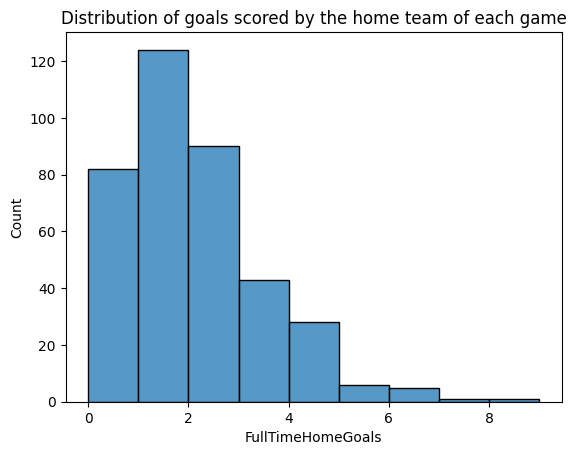

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data = df, x = 'FullTimeHomeGoals', bins = 9).set(title='Distribution of goals scored by the home team of each game')

[Text(0.5, 1.0, 'Distribution of goals scored by the away team of each game')]

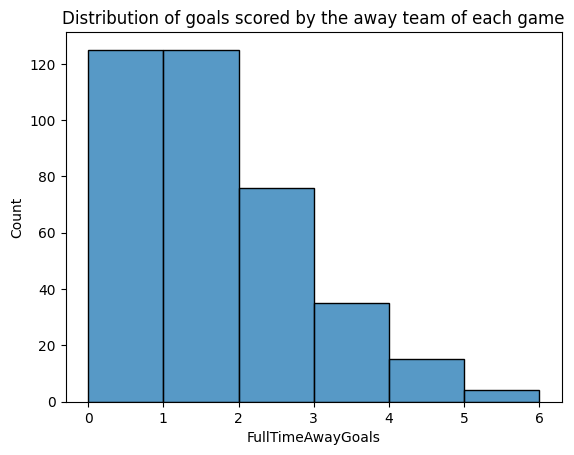

In [ ]:
sns.histplot(data = df, x = 'FullTimeAwayGoals', bins = 6).set(title='Distribution of goals scored by the away team of each game')

[Text(0.5, 1.0, 'Distribution of attendance figures')]

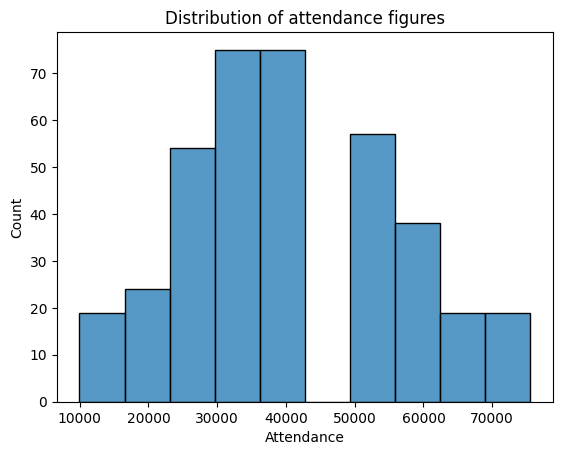

In [ ]:
sns.histplot(data = my_df, x = 'Attendance').set(title='Distribution of attendance figures')

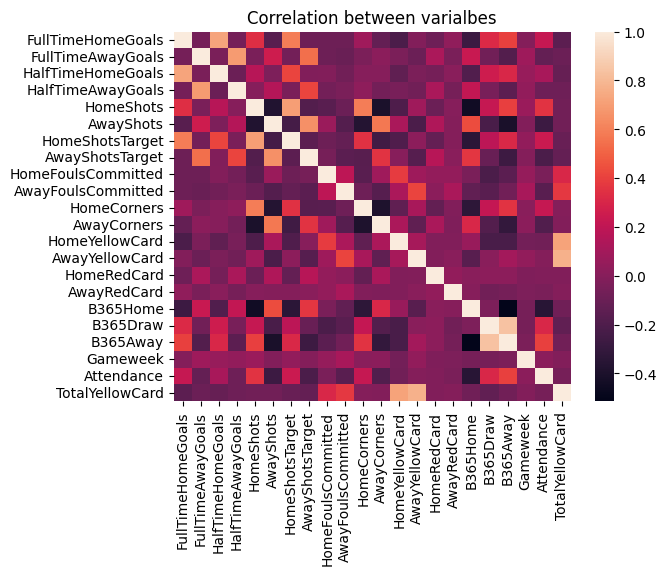

In [ ]:
# Correlation matrix
corr = my_df.corr(numeric_only = True)
sns.heatmap(corr).set(title='Correlation between varialbes');

# The correlation matrix contains many variables. This makes is more difficult to read.
# Therefore it might be beneficial to do a matrix of a selected list of variables.

### 2. **Additional Plots** (10 points): Create at least two more types of plots, such as box plots, scatter plots, or line plots.

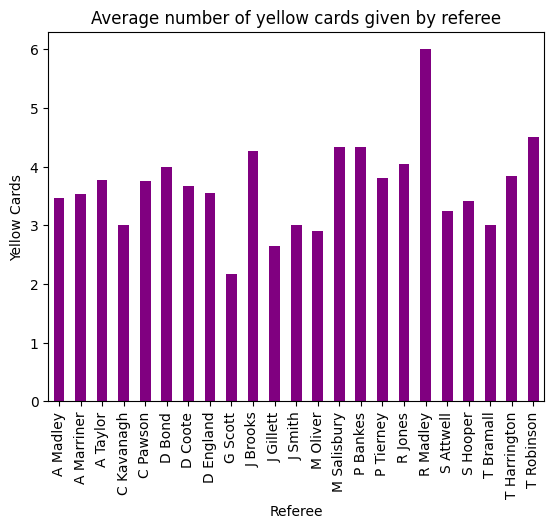

In [ ]:
# Bar plot
my_df['TotalYellowCard'] = my_df['HomeYellowCard'] + my_df['AwayYellowCard']
referee_yellowCards = my_df.groupby('Referee')['TotalYellowCard'].sum()
referee_yellowCards

# There may be differences in the amount of games a referee has managed. Therefore it is valuable to find the percentage of cards per game
referee_summary = my_df.groupby('Referee').agg(TotalYellowCardSum=('TotalYellowCard', 'sum'), TotalGames=('Referee', 'size'))
referee_summary
avg_yellowCards = referee_summary['TotalYellowCardSum'] / referee_summary['TotalGames']

avg_yellowCards.plot(kind='bar', color='purple')
plt.xlabel('Referee')
plt.ylabel('Yellow Cards')
plt.title('Average number of yellow cards given by referee')
plt.xticks(rotation=90)
plt.show()

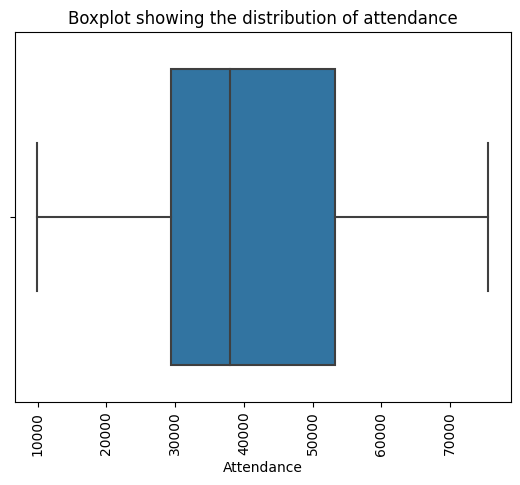

In [ ]:
# Boxplot
sns.boxplot(data = my_df, x = 'Attendance')
plt.title('Boxplot showing the distribution of attendance')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# stadium locations and capacity
# https://en.wikipedia.org/wiki/List_of_Premier_League_stadiums

try:
    import cartopy.crs as ccrs
except ImportError:
    !pip install cartopy
    import cartopy.crs as ccrs

import matplotlib.pyplot as plt

import cartopy.io.img_tiles as cimgt
import numpy as np

coords = {'Community Stadium': (0.171932, 51.29269),
           'Anfield': (-2.960912, 53.430842),
           'City Ground': (-01.0758, 52.5624),
           }

capacity = {'Community Stadium': 20000,
           'Anfield': 60000,
           'City Ground': 22000,
           }
capacities = list(capacity.values())


min_long = min(stadium[0] for stadium in coords.values()) - 3 # additional 5 degree for padding
max_long = max(stadium[0] for stadium in coords.values()) + 2
min_lat = min(stadium[1] for stadium in coords.values()) - 1
max_lat = max(stadium[1] for stadium in coords.values()) + 2

# Create a Stamen Terrain instance
stamen_terrain = cimgt.Stamen('terrain-background')

fig = plt.figure(figsize=(10, 5))

# Create a GeoAxes in the tile's projection
ax = fig.add_subplot(1, 1, 1, projection=stamen_terrain.crs)

# Limit the extent of the map to a small longitude/latitude range
ax.set_extent([min_long, max_long, min_lat, max_lat], crs=ccrs.Geodetic())

# Add the Stamen data at zoom level 8
ax.add_image(stamen_terrain, 8)


colormap = plt.cm.viridis
#colors = colormap(capacities)

# Plotting the cities using the selected cities and their coordinates with colors based on capacity
for (stadium, coord), color in zip(coords.items(), colors):
    plt.plot(coord[0], coord[1], 'ob', markersize=6, color=color, transform=ccrs.PlateCarree())

    # relative alpha level useful for when dots are clustered
    # alpha = capacity[stadium] / max(capacity.values())
    # some way of implementing condition so it only affects dots that there clustered?

# Legend
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=min(capacities), vmax=max(capacities))), ax=ax)
cbar.set_label('Stadium Capacity (People)', rotation=270, labelpad=15)

plt.show();

# plot the map in some way to show where most cards are given or something
# see plot in Supervised learning

### 3. **Advanced Plot** (10 points): Create an advanced plot that uses aesthetic mappings, faceting, or non-standard styles.

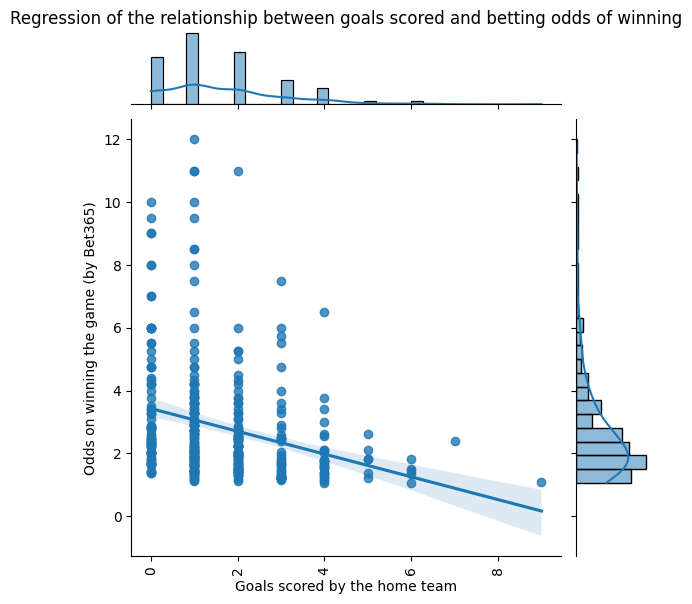

In [ ]:
sns.jointplot(x='FullTimeHomeGoals' , y ='B365Home', data = my_df, kind = 'reg');
plt.xlabel('Goals scored by the home team')
plt.ylabel('Odds on winning the game (by Bet365)')
plt.title('Regression of the relationship between goals scored and betting odds of winning', y = 1.2, fontsize = 12)
plt.xticks(rotation=90)
plt.show()

## Part 4: Describe Your Findings (10 points)

Explain what your plots reveal about your data. Are there surprising patterns or outliers? What are the key insights from your data exploration?


The histograms show the distribution of goals scored is skewed to the right and that away team more often than the home team scores 0 times. The histogram of attendance shows a great variety in the number of fans on the stadiums. Investigating this data shows that the attendance for each home team is rather stable indicating that the stadium may be at capacity for all games. With this lille note is can also be seen that no stadium has a capacity limit of roughly 45,000 people as no games have the interval.

The bar plot shows the average amount of yellow cards each referee gives per game. There is quite a big difference - some give more than double of others. This data can then be used for different things like betting or for the team to utilize a certain play style that fits the referee's style.

The jointplot shows the relationship of odds for the home team to win and the amount of goals scored by the home team. It shows that the lower the odds (the amount times your bet you will get back) the more goals will the home team score. A likely explanation for this is that a better team will score more goals and therefore are the bookmakers lowering the odds.

## Part 5: Bonus: Incorporate External Data (up to 15 points)


Web scraping have been used to enrich the dataset with the attendance figures and gameweek information.

# 2. Predictive analytics

Your Task: Your mission is to apply the knowledge and tools of descriptive analytics to build a predictive model. You will use the same dataset as the one used in Assignment 1 or pick a new one. Your task is to establish a solid data pipeline with preprocessors and apply a supervised learning model.

### Load the dataset from Assignment 1
I have converted the dataframe from Assignment 1 to a csv file. This file can quickly be read instead of having to wait ~20 mintues to web scrape 1140 pages.

In [ ]:
import pandas as pd
df = pd.read_csv('https://raw.github.com/jodaras/BAwP/a2bebeae768a288b38ba5e48465762a19097f826/MyDataset.csv')

#### Risk of error?
I am worried that the change into long format where each game essentially occurs twice in the dataset will lead to some problem with duplicates.
- I think there is risk for some leakage: The model could memorize the duplicates and perform unrealistically well on the test set.
- Also, there could be bias in the use of duplicates

## Basic Requirements

### Predictive Model
To build a predictive model using supervised learning a pipeline must be established.

The pipeline consists of three main steps:
- Preprocessing: With this step it is assured that the data is ready to be worked with. Here missing values are dealth with and others values are either normalized or encoded in a way the model can proess them.
- Defining the model: Here it is decided which model the pipeline should follow.
- Creation and evaluation: In the last step, the model is fitted and the result is evaluated by a measure of error (MAE)



Firstly, the target variable is selected, `y`. For this analysis the target is the amount of total yellow cards in a game. To explain this, some features are selected, `x`. Here all possible features are selected with exception of the target varialbe of two other variables that are closly related to the target. Having knowlegde of the amount of yellow cards given to each team in a game will remove the purpose of finding the total amount (total = home + away).

Next, the dataset is split into a training set and a test set. The distribution of observations are 80% for training and 20% for testing.

In [ ]:
from sklearn.model_selection import train_test_split

# New target: a measure of roughness
# Features: stadium, teams, referee, gameweek(?), goals
# only features that envolve data we have from before the time of prediction

#explanation exposed

# Separate target from predictors
targetCol = 'RoughnessScore'
y = df[targetCol]
#X = df.drop([targetCol, 'HomeYellowCard', 'AwayYellowCard'], axis=1)
X = df[['Date', 'Time', 'Gameweek', 'HomeTeam', 'AwayTeam', 'B365Home', 'B365Away', 'B365Draw', 'Stadium', 'Referee']]

# Train-test split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=0)
X_train.head()

,Date,Time,Gameweek,HomeTeam,AwayTeam,B365Home,B365Away,B365Draw,Stadium,Referee
761,06/08/2022,12:30,1.0,Fulham,Liverpool,11.00,1.25,6.0,Craven Cottage,A Madley
597,08/02/2022,20:00,24.0,Burnley,Man United,5.50,1.61,4.0,Turf Moor,M Dean
317,21/04/2021,18:00,32.0,Tottenham,Southampton,1.75,4.50,3.8,Tottenham Hotspur Stadium,D Coote
860,19/10/2022,19:30,12.0,Brentford,Chelsea,4.75,1.72,3.8,Gtech Community Stadium,J Gillett
1078,26/04/2023,19:45,33.0,Chelsea,Brentford,1.70,4.75,4.0,Stamford Bridge,A Madley


### Preprocessing
The purpose of preprocessing is to make the dataset handlable by the model. The model requires no NA's and values will benefit of being normalized such there are no distortion of proportions. Having no normalization in this dataset would mean that one unit of goals count the same as one unit of attendance, but the range of goals are between 0 and 9 and for attendance the range is approximately from 2,000 to 75,000.

To be able to do the preprocessing, the variables are first divived into numeric and categorical columns.

In [ ]:
numCols = [cname for cname in X_train.columns if X_train[cname].dtype in ['int64', 'float64']]
print(numCols)

df[numCols].isna().sum()

['Gameweek', 'B365Home', 'B365Away', 'B365Draw']


Gameweek    0
B365Home    0
B365Away    0
B365Draw    0
dtype: int64

In [ ]:
catCols = [cname for cname in X_train.columns if X_train[cname].nunique() < 30 and X_train[cname].dtype == "object"]
print(catCols)
df[catCols].isna().sum()

['Time', 'HomeTeam', 'AwayTeam', 'Stadium', 'Referee']


Time        0
HomeTeam    0
AwayTeam    0
Stadium     0
Referee     0
dtype: int64

As seen above, there are no NA's in the dataset, hence there is no need for imputation. Imputation would have taken any NA and replaced it with a value of eg. the mean of the others or the most frequent. Since there is no need for this, imputation is not included in the pipeline.

The numerical values are normalized and the categorical value are encoded to an ordinal scale (0, 1, 2, ...).

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Preprocessing numerical columns
numerical_transformer = MinMaxScaler()

# Preprocessing categorical columns
categorical_transformer = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1,
    encoded_missing_value=-2,
)

# Bundle both preprocessors
preprocessor1 = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numCols),
    ('cat', categorical_transformer, catCols)
])

### Model
The model will make use of a RandomForrest model. A model of this kind has a good predictive accuracy and in general it will also be less prone to overfitting. This means the model should not memorize the traning data and use this kownledge when prediction on new data.

Since the target varialbe is numeric the model type is a regressor, hence the model wil make use of the RandomForrestRegressor.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
model_RFR = RandomForestRegressor(random_state=1, n_estimators=100, max_features = 'log2')  #(what is optimal n?)

By using max_features = log2, the model should be better balanced to reduce overfitting while maintaining performance.

### Evaluation
With evaluation of the model, the level of error is found. This error is expressed in Mean Absolute Error (MAE). MAE has to be seen in relation to the target variable and the lower the number, the better performance.

In [ ]:
from sklearn.metrics import mean_absolute_error

# Bundle preprocessing and modeling code in a pipeline
complete_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor1),
    ('model', model_RFR)
])

# Preprocess the raw training data and fit the model
complete_pipeline.fit(X_train, y_train)

# Preprocess the raw validation data and make predictions
preds = complete_pipeline.predict(X_valid)

# Evaluate the model
score_RFR = mean_absolute_error(y_valid, preds)
print("With the use of the RandomForrestRegressor the MAE is found to be: {}".format(score_RFR))

With the use of the RandomForrestRegressor the MAE is found to be: 22.287456140350876


In [ ]:
avg_roughness = df['RoughnessScore'].mean()

print('Average number of yellow cards per game:', avg_roughness)
print('Percentage of error:', score_RFR / avg_roughness)

Average number of yellow cards per game: 77.40526315789474
Percentage of error: 0.28793205049749554


In principle it means that the prediction error is 0.69 yellow cards per game.

The average number of yellow cards in a game is 3.28 cards which gives a 21% error on the average game.

The immediate interpretation of the error is that the level is quite acceptable.

In [ ]:
complete_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['Gameweek', 'B365Home',
                                                   'B365Away', 'B365Draw']),
                                                 ('cat',
                                                  OrdinalEncoder(encoded_missing_value=-2,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Time', 'HomeTeam',
                                                   'AwayTeam', 'Stadium'])])),
                ('model',
                 RandomForestRegressor(max_features='log2', random_state=1))])

**Investigation of max leaf nodes**

In [ ]:
def get_mae(max_leaf_nodes, X_train, X_valid, y_train, y_valid):
    model = RandomForrestRegressor(max_leaf_nodes=max_leaf_nodes, random_state=1)
    model.fit(X_train, y_train)
    preds_val = model.predict(X_valid)
    mae = mean_absolute_error(y_valid, preds_val)
    return(mae)

In [ ]:
for max_leaf_nodes in range(50, 800, 50):
    model_RFR = RandomForestRegressor(random_state=1, n_estimators=100, max_leaf_nodes = max_leaf_nodes)

    complete_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor1),
    ('model', model_RFR)])

    complete_pipeline.fit(X_train, y_train)

    preds_is = complete_pipeline.predict(X_train)
    preds_oos = complete_pipeline.predict(X_valid)

    score_RFR = mean_absolute_error(y_valid, preds)

    is_mae = mean_absolute_error(y_train, preds_is)
    oos_mae = mean_absolute_error(y_valid, preds_oos)
    print(f"Max leaf nodes: {max_leaf_nodes}  \t In-sample: {is_mae}  \t Out-of-sample: {oos_mae}")

Max leaf nodes: 50  	 In-sample: 15.942752991190071  	 Out-of-sample: 22.189340855345122
Max leaf nodes: 100  	 In-sample: 13.004672896423799  	 Out-of-sample: 22.386854992128235
Max leaf nodes: 150  	 In-sample: 10.995442537081864  	 Out-of-sample: 22.329989561353173
Max leaf nodes: 200  	 In-sample: 9.658112502289613  	 Out-of-sample: 22.334528877830046
Max leaf nodes: 250  	 In-sample: 8.859614616681156  	 Out-of-sample: 22.344246561434225
Max leaf nodes: 300  	 In-sample: 8.39557270631826  	 Out-of-sample: 22.367543220184768
Max leaf nodes: 350  	 In-sample: 8.160795145871141  	 Out-of-sample: 22.351592955476466
Max leaf nodes: 400  	 In-sample: 8.044709729171899  	 Out-of-sample: 22.363456732594894
Max leaf nodes: 450  	 In-sample: 8.002191986437053  	 Out-of-sample: 22.350360000379734
Max leaf nodes: 500  	 In-sample: 7.983588152040455  	 Out-of-sample: 22.33910501949318
Max leaf nodes: 550  	 In-sample: 7.979619883040935  	 Out-of-sample: 22.341301169590647
Max leaf nodes: 600  

From this it can be concluded that the optimal set of leaf nodes is somewhere around 550 nodes.

## Additional Mastery Tasks

### Feature Importance
With feature importance it can be investigated which features have the most influence on the target.

Here the importance of each feature can be seen as a numeric value (0.01 = 1%).

In [ ]:
complete_pipeline.steps[1][1].feature_importances_

array([0.16439846, 0.11270285, 0.11547861, 0.14183147, 0.10460209,
       0.09206613, 0.1637685 , 0.10515189])

Here the importance is plotted as a horizontal bar graph.

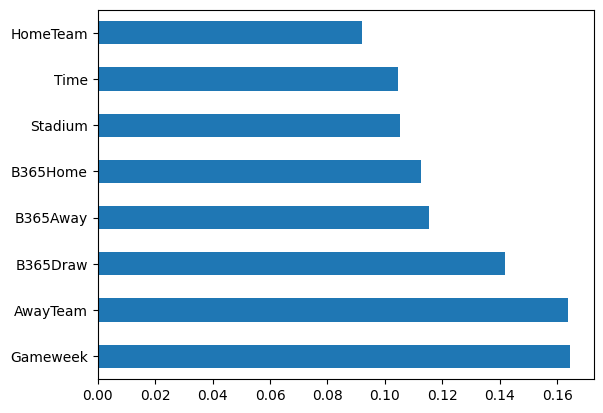

In [ ]:
feat_importances = pd.Series(complete_pipeline.steps[1][1].feature_importances_)    # calc. feature importance
feat_importances.index = list(numCols)+list(catCols)                                # matches importance levels woth respective feature title
feat_importances.nlargest(len(feat_importances)).plot(kind='barh');                 # plots the importance of each feature

**Main take aways**

The features with the most importance are the fouls committed by each team. This relationship between fouls and yellow cards seems quite natural as a precessor to a yellow card is that a foul has been committed. The logical thought is the more fouls, the more (chances for) yellow cards. Also, if the amount of fouls are high, it could indicate a though game where teams tackle alot. However, there is no stringent relationship between fouls and yellow cards as it depend on the style of referee (does he give fouls for every contact or does he allow a greater battle?).

The features `Attendance` and `Gameweek`, however, also have a great importance, but as such no clear explanation can be found. There might be something with the more attendance, the more of a battle, or maybe later in a season some games are played more aggresively as teams try to improve on their position.

Another feature worth pointing out is the `B365Draw`. It indicates the odds for the game to end in a draw. The relation to yellow cards could be that the more equal a game is, the more 'battles' there are = more fouls. Or that a game with high odds indicates one team dominate the other, and the dominated defense must do a lot of tackles.

Lastly, the importance of red cards given are impressingly low. One would think a referee who gives reds cards would be more likely to give more yellow cards.




To investigate the importance of some features, the analysis is done again but now with some features being omitted.

In [ ]:
numCols_new = ['HomeShots', 'AwayShots', 'HomeShotsTarget', 'AwayShotsTarget', 'HomeFoulsCommitted', 'AwayFoulsCommitted', 'HomeRedCard', 'AwayRedCard', ]
numCols_new

['HomeShots',
 'AwayShots',
 'HomeShotsTarget',
 'AwayShotsTarget',
 'HomeFoulsCommitted',
 'AwayFoulsCommitted',
 'HomeRedCard',
 'AwayRedCard']

In [ ]:
# Preprocessing numerical columns
numerical_transformer = MinMaxScaler()

# Preprocessing categorical columns
categorical_transformer = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1,
    encoded_missing_value=-2,
)

# Bundle both preprocessors
preprocessor1 = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numCols_new),
    ('cat', categorical_transformer, catCols)
])

In [ ]:
model_RFR = RandomForestRegressor(random_state=1, n_estimators=100, max_features = 'log2')  #(what is optimal n?)

In [ ]:
from sklearn.metrics import mean_absolute_error

# Bundle preprocessing and modeling code in a pipeline
complete_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor1),
    ('model', model_RFR)
])

# Preprocess the raw training data and fit the model
complete_pipeline.fit(X_train, y_train)

# Preprocess the raw validation data and make predictions
preds = complete_pipeline.predict(X_valid)

# Evaluate the model
score_RFR = mean_absolute_error(y_valid, preds)
print("With the use of the RandomForrestRegressor the MAE is found to be: {}".format(score_RFR))

ValueError: ignored

In [ ]:
complete_pipeline.steps[1][1].feature_importances_

array([0.15703352, 0.1468126 , 0.11873765, 0.10698381, 0.17261493,
       0.17879289, 0.01240039, 0.01178934, 0.04900395, 0.04583092])

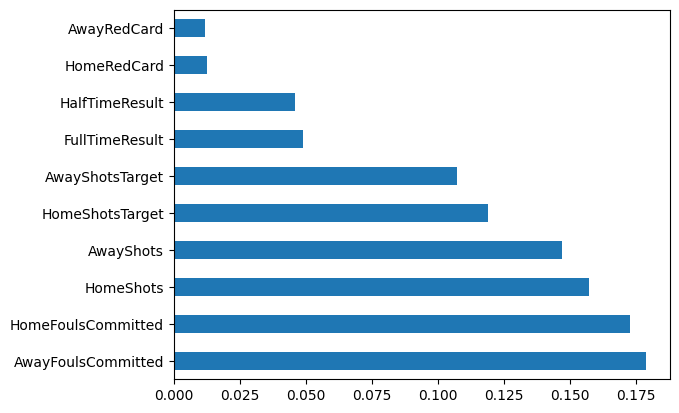

In [ ]:
feat_importances = pd.Series(complete_pipeline.steps[1][1].feature_importances_)    # calc. feature importance
feat_importances.index = list(numCols_new)+list(catCols)                                # matches importance levels woth respective feature title
feat_importances.nlargest(len(feat_importances)).plot(kind='barh');                 # plots the importance of each feature

Once again the fouls committed are of great importance.

Also shots and shots on target have great importance.

### Advanced Feature Engineering
It might be interesting to explore other ways to engineer the features. Therefore, the encoding of the categorical features are changed from the  OrdinalEncoder to the OneHotEncoder.

The same steps are followed and only the encoding is changed in order to compare the MAE's fairly.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Preprocessing categorical columns
categorical_transformer = OneHotEncoder()              # encodes values to 0, 1, 2, ...

# Bundle both preprocessors
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numCols),
    ('cat', categorical_transformer, catCols)
])

In [ ]:
# Bundle preprocessing and modeling code in a pipeline
complete_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model_RFR)
])

# Preprocess the raw training data and fit the model
complete_pipeline.fit(X_train, y_train)

# Preprocess the raw validation data and make predictions
preds = complete_pipeline.predict(X_valid)

# Evaluate the model
score = mean_absolute_error(y_valid, preds)
print("MAE using OneHotEncoder: {}".format(score))

There seem to be only litte difference between the two ways of feature engineering.

The impact may have been bigger had there been more categorical variables such the different encoders had more to work with.

### Different models
One way to compare the use of different models is to follow the same pipeline procedures as before, but now with another model. The preprocessing is the same, hence the pipeline in this section does not include a new step for preprocessing. The same preprocessing is used here as in the original pipeline. It also makes it more compariable. For a more complete comparison, see the section with stacking below.


In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor

In [ ]:
model_HGBR = HistGradientBoostingRegressor(random_state=1, max_leaf_nodes=100)

In [ ]:
from sklearn.metrics import mean_absolute_error

# Bundle preprocessing and modeling code in a pipeline
complete_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor1),
    ('model', model_HGBR)
])

# Preprocess the raw training data and fit the model
complete_pipeline.fit(X_train, y_train)

# Preprocess the raw validation data and make predictions
preds = complete_pipeline.predict(X_valid)

# Evaluate the model
score_HGBR = mean_absolute_error(y_valid, preds)
print("MAE using the complete pipeline: {}".format(score_HGBR))

MAE using the complete pipeline: 22.56836155195723


By changing the model from the RandomForrestRegresson to the HistGradientBoostingRegressor the prediction error has decreased to 0,56 (improvement of ~19%).

### Stacking
With stacking, multiple estimators are used to get a better total result. Essentially, it takes the best from all estimaters and apply on the stacked estimator.

#### Preprocessing
The preprocessing depends on the ending preprocesser. A linear model requires categories to be one-hot encoded, while a tree-based model can make do with an ordinal encoder. A linear model will also require numerical values to be standardized.

For simplicity, the preprocessing is made from scratch in the following code.

In [ ]:
# Tree preprocessing

import numpy as np

from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder

catProcessor_tree = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1,
    encoded_missing_value=-2,
)

numProcessor_tree = SimpleImputer(strategy="mean", add_indicator=True)

treePreprocessor = make_column_transformer(
    (numProcessor_tree, numCols), (catProcessor_tree, catCols)
)
treePreprocessor

ColumnTransformer(transformers=[('simpleimputer',
                                 SimpleImputer(add_indicator=True),
                                 ['Gameweek', 'B365Home', 'B365Away',
                                  'B365Draw']),
                                ('ordinalencoder',
                                 OrdinalEncoder(encoded_missing_value=-2,
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['Time', 'HomeTeam', 'AwayTeam', 'Stadium',
                                  'Referee'])])

In [ ]:
# Linear preprocessing

from sklearn.preprocessing import OneHotEncoder, StandardScaler

catprocessor_linear = OneHotEncoder(handle_unknown="ignore")
numProcessor_linear = make_pipeline(
    StandardScaler(), SimpleImputer(strategy="mean", add_indicator=True)
)

linearPreprocessor = make_column_transformer(
    (numProcessor_linear, numCols), (catprocessor_linear, catCols)
)
linearPreprocessor

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler()),
                                                 ('simpleimputer',
                                                  SimpleImputer(add_indicator=True))]),
                                 ['Gameweek', 'B365Home', 'B365Away',
                                  'B365Draw']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['Time', 'HomeTeam', 'AwayTeam', 'Stadium',
                                  'Referee'])])

#### New pipelines for each model

In [ ]:
from sklearn.ensemble import RandomForestRegressor

RF_pipeline = make_pipeline(treePreprocessor, RandomForestRegressor(random_state=1))
RF_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  ['Gameweek', 'B365Home',
                                                   'B365Away', 'B365Draw']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(encoded_missing_value=-2,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Time', 'HomeTeam',
                                                   'AwayTeam', 'Stadium',
                                                   'Referee'])])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=1))])

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

extra_pipeline = make_pipeline(treePreprocessor, ExtraTreesRegressor(random_state=1))
extra_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  ['Gameweek', 'B365Home',
                                                   'B365Away', 'B365Draw']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(encoded_missing_value=-2,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Time', 'HomeTeam',
                                                   'AwayTeam', 'Stadium',
                                                   'Referee'])])),
                ('extratreesregressor', ExtraTreesRegressor(random_state=1))])

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor

HGBR_pipeline = make_pipeline(
    treePreprocessor, HistGradientBoostingRegressor(random_state=1)
)
HGBR_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  ['Gameweek', 'B365Home',
                                                   'B365Away', 'B365Draw']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(encoded_missing_value=-2,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Time', 'HomeTeam',
                                                   'AwayTeam', 'Stadium',
                                                   'Referee'])])),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(random_state=1))])

In [ ]:
from sklearn.linear_model import LassoCV

lasso_pipeline = make_pipeline(linearPreprocessor, LassoCV())
lasso_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(add_indicator=True))]),
                                                  ['Gameweek', 'B365Home',
                                                   'B365Away', 'B365Draw']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Time', 'HomeTeam',
                                                   'AwayTeam', 'Stadium',
                                                   'Referee'])])),
                ('lassocv', LassoCV())])

#### Stacking regressor

In [ ]:
# Stack regressors

from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

estimators = [
    ("Random Forest", RF_pipeline),
    ("Gradient Boosting", HGBR_pipeline),
    ("ExtraTrees", extra_pipeline),
    #("Lasso", lasso_pipeline)
]

stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())
stacking_regressor

StackingRegressor(estimators=[('Random Forest',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('simpleimputer',
                                                                                 SimpleImputer(add_indicator=True),
                                                                                 ['Gameweek',
                                                                                  'B365Home',
                                                                                  'B365Away',
                                                                                  'B365Draw']),
                                                                                ('ordinalencoder',
                                                                                 OrdinalEncoder(encoded_missing_value=-2,
                                                                                                handle_unknown='use_encoded_value',
                                                                                                unknown_value=-1),
                                                                                 ['Time',
                                                                                  'HomeTeam',
                                                                                  'AwayTe...
                                                ColumnTransformer(transformers=[('simpleimputer',
                                                                                 SimpleImputer(add_indicator=True),
                                                                                 ['Gameweek',
                                                                                  'B365Home',
                                                                                  'B365Away',
                                                                                  'B365Draw']),
                                                                                ('ordinalencoder',
                                                                                 OrdinalEncoder(encoded_missing_value=-2,
                                                                                                handle_unknown='use_encoded_value',
                                                                                                unknown_value=-1),
                                                                                 ['Time',
                                                                                  'HomeTeam',
                                                                                  'AwayTeam',
                                                                                  'Stadium',
                                                                                  'Referee'])])),
                                               ('extratreesregressor',
                                                ExtraTreesRegressor(random_state=1))]))],
                  final_estimator=RidgeCV())

#### Measure and plot of results

Random Forest
Evaluation in 2.28 seconds
Gradient Boosting
Evaluation in 2.12 seconds
ExtraTrees
Evaluation in 1.39 seconds
Stacking Regressor
Evaluation in 27.89 seconds


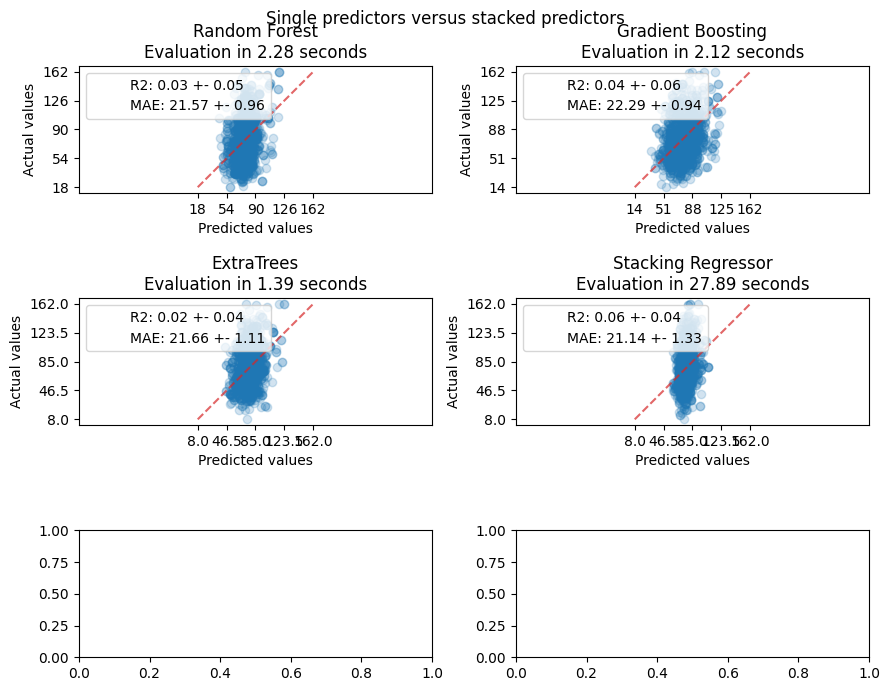

In [ ]:
import time

import matplotlib.pyplot as plt

from sklearn.metrics import PredictionErrorDisplay
from sklearn.model_selection import cross_val_predict, cross_validate

fig, axs = plt.subplots(3, 2, figsize=(9, 7))
axs = np.ravel(axs)

for ax, (name, est) in zip(
    axs, estimators + [("Stacking Regressor", stacking_regressor)]
):
    scorers = {"R2": "r2", "MAE": "neg_mean_absolute_error"}

    start_time = time.time()
    scores = cross_validate(
        est, X, y, scoring=list(scorers.values()), n_jobs=-1, verbose=0
    )
    elapsed_time = time.time() - start_time
    print(f"{name}\nEvaluation in {elapsed_time:.2f} seconds")
    y_pred = cross_val_predict(est, X, y, n_jobs=-1, verbose=0)
    scores = {
        key: (
            f"{np.abs(np.mean(scores[f'test_{value}'])):.2f} +- "
            f"{np.std(scores[f'test_{value}']):.2f}"
        )
        for key, value in scorers.items()
    }

    display = PredictionErrorDisplay.from_predictions(
        y_true=y,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        ax=ax,
        scatter_kwargs={"alpha": 0.2, "color": "tab:blue"},
        line_kwargs={"color": "tab:red"},
    )
    ax.set_title(f"{name}\nEvaluation in {elapsed_time:.2f} seconds")

    for name, score in scores.items():
        ax.plot([], [], " ", label=f"{name}: {score}")
    ax.legend(loc="upper left")

plt.suptitle("Single predictors versus stacked predictors")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

We see the benefit of model stacking as the stacking regressor has the lowest MAE and the highest degree of explanation. The trade-off of this however, is the processing time.

Using this stacking regressor greatly improves the MAE and even with a high degree of explanation. The level of improvement seem to be very significant!

# 3. Linear and Integer Programming with PuLP

Venture into the realm of optimization with a focus on linear and integer programming. Using PuLP and the dataset you've familiarized yourself with in previous assignments, craft optimization models to derive fresh insights. Here are the tasks awaiting your exploration!

In [6]:
# Load dataset
import pandas as pd
df = pd.read_csv('https://raw.github.com/jodaras/BAwP/a2bebeae768a288b38ba5e48465762a19097f826/MyDataset.csv')
df

,Div,Gameweek,Date,Time,Stadium,Attendance,HomeTeam,AwayTeam,FullTimeHomeGoals,FullTimeAwayGoals,...,AwayYellowCard,HomeRedCard,AwayRedCard,B365Home,B365Draw,B365Away,TotalYellowCard,TotalRedCard,TotalFoul,RoughnessScore
0,PL,1.0,12/09/2020,12:30,Craven Cottage,21825.809524,Fulham,Arsenal,0,3,...,2,0,0,6.00,4.33,1.53,4,0,24,88
1,PL,1.0,12/09/2020,15:00,Selhurst Park,23598.100000,Crystal Palace,Southampton,1,0,...,1,0,0,3.10,3.25,2.37,3,0,28,86
2,PL,1.0,12/09/2020,17:30,Anfield,48188.250000,Liverpool,Leeds,4,3,...,0,0,0,1.28,6.00,9.50,1,0,18,46
3,PL,1.0,12/09/2020,20:00,London Stadium,57694.075000,West Ham,Newcastle,0,2,...,2,0,0,2.15,3.40,3.40,4,0,26,92
4,PL,1.0,13/09/2020,14:00,The Hawthorns,5371.000000,West Brom,Leicester,0,3,...,1,0,0,3.80,3.60,1.95,2,0,24,68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,PL,38.0,28/05/2023,16:30,Goodison Park,39201.000000,Everton,Bournemouth,1,0,...,3,0,0,1.50,4.50,6.50,4,0,22,84
1136,PL,38.0,28/05/2023,16:30,Elland Road,36871.000000,Leeds,Tottenham,1,4,...,0,0,0,2.75,3.80,2.30,3,0,14,58
1137,PL,38.0,28/05/2023,16:30,King Power Stadium,32183.000000,Leicester,West Ham,2,1,...,1,0,0,1.91,3.80,3.60,2,0,16,52
1138,PL,38.0,28/05/2023,16:30,Old Trafford,73465.000000,Man United,Fulham,2,1,...,2,0,0,1.50,4.33,6.00,3,0,28,86


In [220]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df

<ipython-input-220-5fe302693129>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Date'] = pd.to_datetime(df['Date'])


,Div,Gameweek,Date,Time,Stadium,Attendance,HomeTeam,AwayTeam,FullTimeHomeGoals,FullTimeAwayGoals,...,HomeRedCard,AwayRedCard,B365Home,B365Draw,B365Away,TotalYellowCard,TotalRedCard,TotalFoul,RoughnessScore,Year
0,PL,1.0,2020-12-09,12:30,Craven Cottage,21825.809524,Fulham,Arsenal,0,3,...,0,0,6.00,4.33,1.53,4,0,24,88,2020
1,PL,1.0,2020-12-09,15:00,Selhurst Park,23598.100000,Crystal Palace,Southampton,1,0,...,0,0,3.10,3.25,2.37,3,0,28,86,2020
2,PL,1.0,2020-12-09,17:30,Anfield,48188.250000,Liverpool,Leeds,4,3,...,0,0,1.28,6.00,9.50,1,0,18,46,2020
3,PL,1.0,2020-12-09,20:00,London Stadium,57694.075000,West Ham,Newcastle,0,2,...,0,0,2.15,3.40,3.40,4,0,26,92,2020
4,PL,1.0,2020-09-13,14:00,The Hawthorns,5371.000000,West Brom,Leicester,0,3,...,0,0,3.80,3.60,1.95,2,0,24,68,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,PL,38.0,2023-05-28,16:30,Goodison Park,39201.000000,Everton,Bournemouth,1,0,...,0,0,1.50,4.50,6.50,4,0,22,84,2023
1136,PL,38.0,2023-05-28,16:30,Elland Road,36871.000000,Leeds,Tottenham,1,4,...,0,0,2.75,3.80,2.30,3,0,14,58,2023
1137,PL,38.0,2023-05-28,16:30,King Power Stadium,32183.000000,Leicester,West Ham,2,1,...,0,0,1.91,3.80,3.60,2,0,16,52,2023
1138,PL,38.0,2023-05-28,16:30,Old Trafford,73465.000000,Man United,Fulham,2,1,...,0,0,1.50,4.33,6.00,3,0,28,86,2023


In [ ]:
# Load package
try:
  from pulp import *
except:
  !pip install pulp
  from pulp import *

## Part 1: Clustering through Warehouse Location Problem (WLP)
Clustering is about grouping data points based on similarity. Here, we'll use a variation of the WLP to achieve this.



**Steps:**

Preprocess your dataset such that each data point could potentially act as both a warehouse and a customer.

Calculate distances between each pair of data points. You may choose the distance metric; however, Euclidean is often the default choice.

Formulate the WLP with the following considerations:
- Each data point is both a potential warehouse and a customer.
- Decide on the number of warehouses (clusters) that seems appropriate.
- Solve the problem using PuLP and analyze the results:
- Identify data points chosen as warehouses (cluster centers).
- Understand the assignment of other data points (customers) to these warehouses.

**Caution:**

If your dataset has a large number of instances, this task can become computationally intensive. Consider working with a subset or be prepared for longer computation times.

**Things to consider**

- Can/should I incoorporate meaningful cost? - no?
- Capacity and max number of clusters
  - How to decide?
  - If manually: justify choice
- HomeTeam / Gameweek / Other?


- Interpretation
- Bonus: How to colorcode clusters in scatterplot

#### Grouped by HomeTeam


In [335]:
# Model definition
model = LpProblem('WLP', LpMinimize)

In [336]:
# Aggregate data such data is grouped by team or gameweek
# This is done so it is easier to make use of the result (otherwise a team could be a cluster twice)
# The downside of this, however, is that their only is 24 datapoints
aggregated_data = df.groupby('HomeTeam').agg({'RoughnessScore': 'mean'}).reset_index()

In [337]:
aggregated_data

,HomeTeam,RoughnessScore
0,Arsenal,72.596491
1,Aston Villa,82.140351
2,Bournemouth,75.894737
3,Brentford,69.315789
4,Brighton,83.438596
5,Burnley,66.000000
6,Chelsea,80.526316
7,Crystal Palace,80.982456
8,Everton,79.263158
9,Fulham,77.631579


In [338]:
# Make data points
dataPoints = aggregated_data.to_dict(orient = "index")

In [339]:
# Set capacity and cost
for l in dataPoints:
  dataPoints[l]["capacity"] = 5    # the maximum number of nodes a cluster can hold
  # dataPoints[l]["cost"] = 1      # not useful
list(dataPoints.items())[0:1]

[(0,
  {'HomeTeam': 'Arsenal', 'RoughnessScore': 72.59649122807018, 'capacity': 5})]

In [340]:
# All datapoints must be assigned to one (and only one) cluster
for c in dataPoints:
  dataPoints[c]["demand"] = 1
list(dataPoints.items())[0:1]

[(0,
  {'HomeTeam': 'Arsenal',
   'RoughnessScore': 72.59649122807018,
   'capacity': 5,
   'demand': 1})]

In [341]:
# Get the distances
distances = {}
for w in dataPoints:
  for c in dataPoints:
    distances[str(w)+"-"+str(c)] = (abs(dataPoints[w]["RoughnessScore"]**2 - dataPoints[c]["RoughnessScore"]**2))**0.5

In [342]:
# Decision variables
isClusterCenter = LpVariable.dict("cluster",dataPoints.keys(),0,1,cat=LpInteger)
assignment = LpVariable.dict("assign",distances.keys(),0,1)

In [343]:
# Objective function
model += lpSum(lpSum(assignment[str(l)+"-"+str(c)] * distances[str(l)+"-"+str(c)] for c in dataPoints) for l in dataPoints)

In [344]:
# Contraints
for c in dataPoints:
  model += lpSum(assignment[str(l)+"-"+str(c)] for l in dataPoints) >= dataPoints[c]["demand"]
for l in dataPoints:
  model += lpSum(assignment[str(l)+"-"+str(c)] for c in dataPoints) <= isClusterCenter[l] * dataPoints[l]["capacity"]
model += lpSum(isClusterCenter[l] for l in dataPoints) == 8   # set number of clusters

In [345]:
# Solve
model.solve()

1

In [346]:
# See all cluster centres
print("=== Clusters ===")
for w in dataPoints:
  if isClusterCenter[w].varValue > 0.8:
    print(dataPoints[w]["HomeTeam"]) #, isClusterCenter[w].varValue)

=== Clusters ===
Aston Villa
Man City
Man United
Nott'm Forest
Southampton
Watford
West Brom
Wolves


In [347]:
# See all sets of cluster + nodes
print("=== Clusters and the related notes ===")
for s in assignment:
  if assignment[s].varValue > 0:
    warehouseCustomer = s.split("-")
    print(dataPoints[int(warehouseCustomer[0])]["HomeTeam"], "-", dataPoints[int(warehouseCustomer[1])]["HomeTeam"], "( Distance", round(distances[s],1),")") #  assignment[s].varValue

=== Clusters and the related notes ===
Aston Villa - Aston Villa ( Distance 0.0 )
Aston Villa - Brighton ( Distance 14.7 )
Aston Villa - Crystal Palace ( Distance 13.7 )
Aston Villa - Newcastle ( Distance 2.4 )
Man City - Burnley ( Distance 9.6 )
Man City - Man City ( Distance 0.0 )
Man City - West Ham ( Distance 12.6 )
Man United - Arsenal ( Distance 11.8 )
Man United - Leicester ( Distance 6.0 )
Man United - Man United ( Distance 0.0 )
Man United - Norwich ( Distance 4.5 )
Nott'm Forest - Nott'm Forest ( Distance 0.0 )
Southampton - Bournemouth ( Distance 6.9 )
Southampton - Southampton ( Distance 0.0 )
Watford - Chelsea ( Distance 15.9 )
Watford - Everton ( Distance 7.1 )
Watford - Fulham ( Distance 14.4 )
Watford - Sheffield United ( Distance 7.1 )
Watford - Watford ( Distance 0.0 )
West Brom - Brentford ( Distance 4.7 )
West Brom - Liverpool ( Distance 11.3 )
West Brom - West Brom ( Distance 0.0 )
Wolves - Leeds ( Distance 14.6 )
Wolves - Tottenham ( Distance 18.8 )
Wolves - Wolve

#### Grouped by HomeTeam and Year

In [294]:
# Model definition
model = LpProblem('WLP', LpMinimize)

In [295]:
# Randomly select observations
# import random as rd
# df_subset = df.sample(n=50)

In [296]:
# Aggregate data such data is grouped by team or gameweek
# This is done so it is easier to make use of the result (otherwise a team could be a cluster twice)
# The downside of this, however, is that their only is 24 datapoints
aggregated_data = df.groupby(['HomeTeam', 'Year']).agg({'RoughnessScore': 'mean'}).reset_index()

# Not aggregated: show teams with season!

In [297]:
aggregated_data

,HomeTeam,Year,RoughnessScore
0,Arsenal,2020,79.750000
1,Arsenal,2021,70.100000
2,Arsenal,2022,76.588235
3,Arsenal,2023,66.333333
4,Aston Villa,2020,91.428571
...,...,...,...
81,West Ham,2023,51.800000
82,Wolves,2020,91.500000
83,Wolves,2021,81.300000
84,Wolves,2022,87.157895


In [298]:
# Make data points
dataPoints = aggregated_data.to_dict(orient = "index")

In [299]:
# Set capacity and cost
for l in dataPoints:
  dataPoints[l]["capacity"] = 8    # the maximum number of nodes a cluster can hold
  # dataPoints[l]["cost"] = 1      # not useful
list(dataPoints.items())[0:1]

[(0,
  {'HomeTeam': 'Arsenal',
   'Year': 2020,
   'RoughnessScore': 79.75,
   'capacity': 8})]

In [300]:
# All datapoints must be assigned to one (and only one) cluster
for c in dataPoints:
  dataPoints[c]["demand"] = 1
list(dataPoints.items())[0:1]

[(0,
  {'HomeTeam': 'Arsenal',
   'Year': 2020,
   'RoughnessScore': 79.75,
   'capacity': 8,
   'demand': 1})]

In [301]:
# Get the distances
distances = {}
for w in dataPoints:
  for c in dataPoints:
    distances[str(w)+"-"+str(c)] = (abs(dataPoints[w]["RoughnessScore"]**2 - dataPoints[c]["RoughnessScore"]**2))**0.5

In [302]:
# Decision variables
isClusterCenter = LpVariable.dict("cluster",dataPoints.keys(),0,1,cat=LpInteger)
assignment = LpVariable.dict("assign",distances.keys(),0,1)

In [303]:
# Objective function
model += lpSum(lpSum(assignment[str(l)+"-"+str(c)] * distances[str(l)+"-"+str(c)] for c in dataPoints) for l in dataPoints)

In [304]:
# Contraints
for c in dataPoints:
  model += lpSum(assignment[str(l)+"-"+str(c)] for l in dataPoints) >= dataPoints[c]["demand"]
for l in dataPoints:
  model += lpSum(assignment[str(l)+"-"+str(c)] for c in dataPoints) <= isClusterCenter[l] * dataPoints[l]["capacity"]
model += lpSum(isClusterCenter[l] for l in dataPoints) == 16   # set number of clusters

In [305]:
# Solve
model.solve()

1

In [306]:
# See all cluster centres
print("=== Clusters ===")
for w in dataPoints:
  if isClusterCenter[w].varValue > 0.8:
    print(dataPoints[w]["HomeTeam"], "-", dataPoints[w]["Year"]) #, isClusterCenter[w].varValue)

=== Clusters ===
Arsenal - 2023
Aston Villa - 2020
Aston Villa - 2022
Aston Villa - 2023
Brentford - 2022
Burnley - 2020
Crystal Palace - 2021
Crystal Palace - 2022
Everton - 2020
Fulham - 2023
Man United - 2023
Norwich - 2022
Southampton - 2022
Southampton - 2023
Tottenham - 2023
Watford - 2021


In [307]:
# See all sets of cluster + nodes
print("=== Clusters and the related notes ===")
for s in assignment:
  if assignment[s].varValue > 0:
    warehouseCustomer = s.split("-")
    print(dataPoints[int(warehouseCustomer[0])]["HomeTeam"], dataPoints[int(warehouseCustomer[0])]["Year"], "-", dataPoints[int(warehouseCustomer[1])]["HomeTeam"], dataPoints[int(warehouseCustomer[1])]["Year"], "( Distance", round(distances[s],1),")") #  assignment[s].varValue

=== Clusters and the related notes ===
Arsenal 2023 - Arsenal 2023 ( Distance 0.0 )
Arsenal 2023 - Brentford 2023 ( Distance 4.5 )
Arsenal 2023 - Fulham 2022 ( Distance 6.7 )
Arsenal 2023 - Leicester 2022 ( Distance 6.6 )
Arsenal 2023 - Man City 2023 ( Distance 6.0 )
Arsenal 2023 - Watford 2022 ( Distance 11.1 )
Aston Villa 2020 - Aston Villa 2020 ( Distance 0.0 )
Aston Villa 2020 - Fulham 2020 ( Distance 8.8 )
Aston Villa 2020 - Wolves 2020 ( Distance 3.6 )
Aston Villa 2022 - Arsenal 2022 ( Distance 9.5 )
Aston Villa 2022 - Aston Villa 2022 ( Distance 0.0 )
Aston Villa 2022 - Chelsea 2020 ( Distance 0.0 )
Aston Villa 2022 - Crystal Palace 2020 ( Distance 8.7 )
Aston Villa 2022 - Man United 2020 ( Distance 6.2 )
Aston Villa 2022 - Man United 2021 ( Distance 9.6 )
Aston Villa 2023 - Aston Villa 2023 ( Distance 0.0 )
Aston Villa 2023 - Brighton 2023 ( Distance 12.8 )
Aston Villa 2023 - Leeds 2021 ( Distance 8.7 )
Aston Villa 2023 - Newcastle 2022 ( Distance 10.4 )
Aston Villa 2023 - Wolv

#### Multiple variables

In [185]:
# Model definition
model = LpProblem('WLP', LpMinimize)

In [186]:
# Set seed
import random as rd

rd.seed(1)

num_samples = 50
random_indices = rd.sample(range(len(df)), k = num_samples)
random_rows = df.iloc[random_indices]

df_subset = pd.DataFrame(random_rows)

In [188]:
# Make data points
dataPoints = df_subset.to_dict(orient = "index")

In [189]:
# Set capacity and cost
for l in dataPoints:
  dataPoints[l]["capacity"] = 10    # the maximum number of nodes a cluster can hold
#list(dataPoints.items())[0:1]

In [190]:
# All datapoints must be assigned to one (and only one) cluster
for c in dataPoints:
  dataPoints[c]["demand"] = 1
#list(dataPoints.items())[0:1]

In [191]:
columns_to_include = ['TotalYellowCard', 'RoughnessScore', 'B365Home', 'B365Away']

df_col = pd.DataFrame({col: [item[col] for item in dataPoints.values()] for col in columns_to_include}, index=dataPoints.keys())

In [192]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_col_normalized = pd.DataFrame(scaler.fit_transform(df_col), columns=df_col.columns, index=df_col.index)

In [193]:
def getDistance(instance1, instance2):
  val1 = instance1.values
  val2 = instance2.values
  dist_man = sum(abs(val1 - val2))          # manhattan distance
  dist_euc = sum((val1 - val2)**2)**0.5     # euclidean distance
  return(dist_euc)

In [194]:
# Get the distances
distance = {}
for i, index1 in enumerate(df_col_normalized.index):
  for j, index2 in enumerate(df_col_normalized.index):
    distance[str(index1)+"-"+str(index2)] = getDistance(df_col_normalized.loc[index1, :], df_col_normalized.loc[index2, :])

In [195]:
# Decision variables
isClusterCenter = LpVariable.dict("cluster",dataPoints.keys(),0,1,cat=LpInteger)
assignment = LpVariable.dict("assign",distance.keys(),0,1)

In [196]:
# Objective function
model += lpSum(lpSum(assignment[str(l)+"-"+str(c)] * distance[str(l)+"-"+str(c)] for c in dataPoints) for l in dataPoints)

In [197]:
# Contraints
for c in dataPoints:
  model += lpSum(assignment[str(l)+"-"+str(c)] for l in dataPoints) >= dataPoints[c]["demand"]
for l in dataPoints:
  model += lpSum(assignment[str(l)+"-"+str(c)] for c in dataPoints) <= isClusterCenter[l] * dataPoints[l]["capacity"]
model += lpSum(isClusterCenter[l] for l in dataPoints) == 10   # set number of clusters

In [198]:
# Solve
model.solve()

1

In [199]:
# See all cluster centres
print("=== Clusters ===")
for w in dataPoints:
  if isClusterCenter[w].varValue > 0.8:
    print(dataPoints[w]["HomeTeam"], dataPoints[w]["Date"]) #, isClusterCenter[w].varValue)

=== Clusters ===
Nott'm Forest 05/02/2023
Everton 27/01/2021
West Ham 24/10/2021
Burnley 03/02/2021
Leicester 18/10/2020
Liverpool 24/10/2020
Sheffield United 31/10/2020
Man City 26/04/2023
Brentford 28/05/2023
Southampton 28/05/2023


In [200]:
# See all sets of cluster + nodes
print("=== Clusters and the related notes ===")
for s in assignment:
  if assignment[s].varValue > 0:
    warehouseCustomer = s.split("-")
    print(dataPoints[int(warehouseCustomer[0])]["HomeTeam"], dataPoints[int(warehouseCustomer[0])]["Date"], "-", dataPoints[int(warehouseCustomer[1])]["HomeTeam"], dataPoints[int(warehouseCustomer[1])]["Date"], "( Distance", round(distance[s],1),")") #  assignment[s].varValue

=== Clusters and the related notes ===
Nott'm Forest 05/02/2023 - Nott'm Forest 05/02/2023 ( Distance 0.0 )
Nott'm Forest 05/02/2023 - Aston Villa 13/05/2023 ( Distance 0.2 )
Nott'm Forest 05/02/2023 - Brighton 26/09/2020 ( Distance 0.2 )
Nott'm Forest 05/02/2023 - Norwich 16/10/2021 ( Distance 0.3 )
Nott'm Forest 05/02/2023 - Norwich 31/10/2021 ( Distance 0.2 )
Nott'm Forest 05/02/2023 - West Ham 03/10/2021 ( Distance 0.2 )
Nott'm Forest 05/02/2023 - Watford 12/02/2022 ( Distance 0.2 )
Everton 27/01/2021 - Fulham 31/12/2022 ( Distance 0.3 )
Everton 27/01/2021 - Everton 27/01/2021 ( Distance 0.0 )
Everton 27/01/2021 - Wolves 30/10/2020 ( Distance 0.2 )
Everton 27/01/2021 - West Brom 13/09/2020 ( Distance 0.1 )
Everton 27/01/2021 - Arsenal 26/12/2022 ( Distance 0.3 )
Everton 27/01/2021 - Fulham 20/10/2022 ( Distance 0.1 )
Everton 27/01/2021 - Brentford 13/08/2021 ( Distance 0.3 )
West Ham 24/10/2021 - Everton 19/12/2020 ( Distance 0.1 )
West Ham 24/10/2021 - Fulham 20/02/2021 ( Distance

#### How to understand

In [204]:
df.groupby("HomeTeam")['RoughnessScore'].mean().sort_values(ascending=False)
# df.groupby(["HomeTeam", "Season"])['RoughnessScore'].mean().sort_values(ascending=False)
# aggregate by the columns chosen?

HomeTeam
Nott'm Forest       93.789474
Leeds               90.140351
Wolves              88.947368
Tottenham           86.947368
Brighton            83.438596
Newcastle           82.175439
Aston Villa         82.140351
Crystal Palace      80.982456
Chelsea             80.526316
Everton             79.263158
Watford             78.947368
Sheffield United    78.631579
Fulham              77.631579
Bournemouth         75.894737
Southampton         75.578947
Norwich             73.684211
Man United          73.543860
Leicester           73.298246
Arsenal             72.596491
Liverpool           70.385965
West Brom           69.473684
Brentford           69.315789
Burnley             66.000000
Man City            65.298246
West Ham            64.070175
Name: RoughnessScore, dtype: float64

This somewhat confirms the cluster. Most teams who are in the same cluster are located closely when looking on roughness for all games.

In [71]:
colors = ['green', 'blue', 'red', 'yellow', 'orange', 'green', 'blue', 'red', 'yellow', 'orange']
cluster_colors = {}
c = 0
for w in dataPoints:
  if isClusterCenter[w].varValue > 0.8:
    cluster_colors[str(dataPoints[w]['HomeTeam'])] = colors[c]
    c = c+1

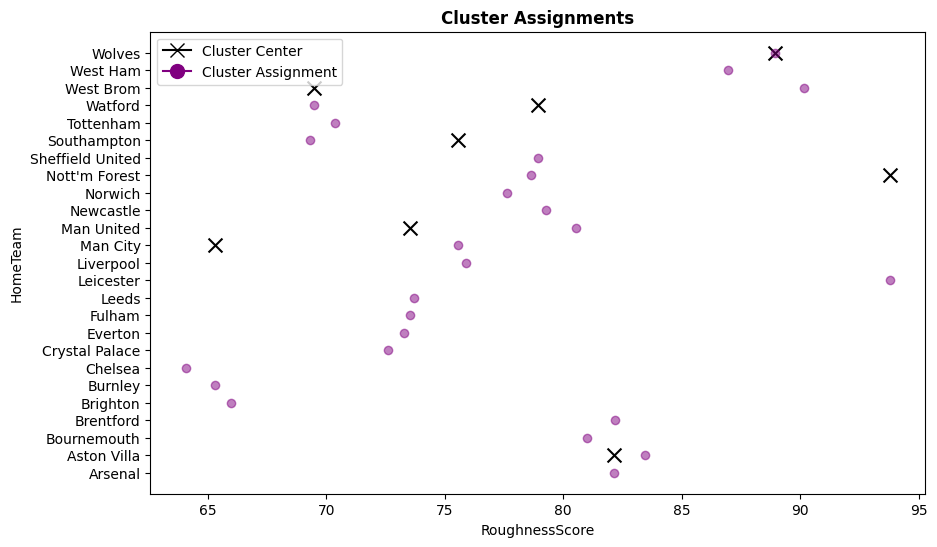

In [348]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Create a scatter plot for cluster centers
for w in dataPoints:
    if isClusterCenter[w].varValue > 0.8:
        plt.scatter(dataPoints[w]["RoughnessScore"], w, c = 'black', marker='x', s=100)

# Create a scatter plot for cluster assignments
for s in assignment:
    if assignment[s].varValue > 0:
        warehouseCustomer = s.split("-")
        plt.scatter(dataPoints[int(warehouseCustomer[1])]["RoughnessScore"], warehouseCustomer[1], c='purple', marker='o', alpha=0.5)

# Create custom legend handles and labels
center_handle = plt.Line2D([0], [0], marker='x', color='black', markersize=10, label='Cluster Center')
assignment_handle = plt.Line2D([0], [0], marker='o', color='purple', markersize=10, label='Cluster Assignment')

# Combine handles and labels for the legend
handles = [center_handle, assignment_handle]
labels = [h.get_label() for h in handles]

# Display the legend with the combined handles and labels
plt.legend(handles=handles, labels=labels)

plt.title('Cluster Assignments', fontweight = 'bold')
plt.xlabel('RoughnessScore')
plt.ylabel('HomeTeam')
team_names = [dataPoints[key]["HomeTeam"] for key in dataPoints.keys()]
plt.yticks(list(dataPoints.keys()), team_names)
plt.show()

Centers are marked correctly with crosses, but they also appear with other levels of roughness. WHY?

## Part 2: Bridging Predictive to Prescriptive Models

**Contextual Understanding:**

Begin by understanding the impact and implications of your predictive model's results. Here are some examples to spark your thoughts:
- Hotel Bookings: If your model predicts the likelihood of a hotel booking being canceled, how can this information be used for better room allocation or dynamic pricing strategy?
- Climate Change: If you're predicting factors influencing global temperatures or CO2 levels, can this be used to devise strategies for CO2 abatement, renewable energy allocations, or policy optimizations?
- Fantasy Sports: Predicting player performance in the next game? How could you use this to decide the optimal roster for your fantasy team, factoring in player costs or other constraints?
- E-commerce or Retail: If you're forecasting product demand, how can the predictions assist in inventory management, discount strategies, or supply chain optimizations?


**Prescriptive Formulation:**

Based on the implications, ideate a hypothetical scenario where decisions need to be made using the predictions. Describe potential decision variables, constraints, and objectives that would make sense for this scenario.

**Pulp Implementation (Optional):**

If you feel that your prescriptive formulation can be translated into a linear/integer programming model, attempt to implement it using Pulp. Even a simplified version will suffice.

**Discussion:**

Reflect on the process of translating a predictive insight into actionable decisions. What challenges did you encounter? What benefits can you foresee in integrating predictive and prescriptive analytics in a real-world setting?



#### Contextual understanding
What strategy should a team implement based on the opponent, referee etc.
How to set the odds on yellow cards

#### Prescriptive Formulation
Ideate hypothetiocal scenarios and describe potential decision variables, constraints, and objectives that would make sense for this scenario.


Decision variables: Pick players that fit the style (think of fifa stats)

Constraints: 11 players, 3-5 defenders,

Objectives: min difference in roughness between team and opponent

#### Pulp Implementation (Optional)
Do the modelling

take avg roughness of abitrary opponent

#### Discussion
Objective function: what do we actually measure


If you just compile a team of best individual positions, what about chemistry